# ODE Model for Metabolites and Lactylation in Microglia
System of equations (glucose, pyruvate, lactate and inflammation):
$$\frac{dG}{dt}=\Lambda(I) (G_E-G) -\frac{V_{P}G}{K_P +G}h^+_{1}(L)$$
$$\frac{dP}{dt}=\frac{V_{P}G}{K_P +G}h^+_{1}(L) -\Delta(I)\frac{V_{L}P}{K_L + P}h^+_{2}(L)-(1-\Delta(I))\frac{V_{T}P}{K_T + P}$$
$$\frac{dL}{dt}=\Delta(I)\frac{V_{L}P}{K_L + P}h^+_{2}(L) + \Sigma(I)(L_E-L)$$
$$\frac{dI}{dt}=\frac{a_{LI}L}{b_{LI}+L}-d_II$$
Where
$$ \Lambda(I) = \frac{a_{IG}I }{b_{IG} + I} + \lambda$$
$$\Sigma(I) = \frac{a_{IL}I  }{b_{IL} + I}+\sigma$$
$$ \Delta(I) = \frac{a_{IL}I}{b_{IL} + I}+\delta$$
$$h^+_{1}(L) = H_1 + \frac{a_{LG}L}{b_{LG}+L}$$
$$h^+_{2}(L) = H_2 + \frac{a_{LP}L}{b_{LP}+L}$$
which represent inflammation's upregulation of glycoloysis and lactate production and lactate's upregulation of enzymes PKM2 and LDHA (through histone lactylation).
All parameters are greater than or equal to zero, and there is a further constraint that $1-\Delta(I) \geq 0$.


### Comparison to Experimental Data
We use validate our model by reproducing a knockout biological experiment in Pan, et al., 2022.

## Uses nonstiff ODE Solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from SALib.sample import saltelli
from SALib.analyze import sobol
# to plot multiple plots
import pylab
import time
import random
import matplotlib.pyplot as plt


## Plot Solution for Base Parameter Set

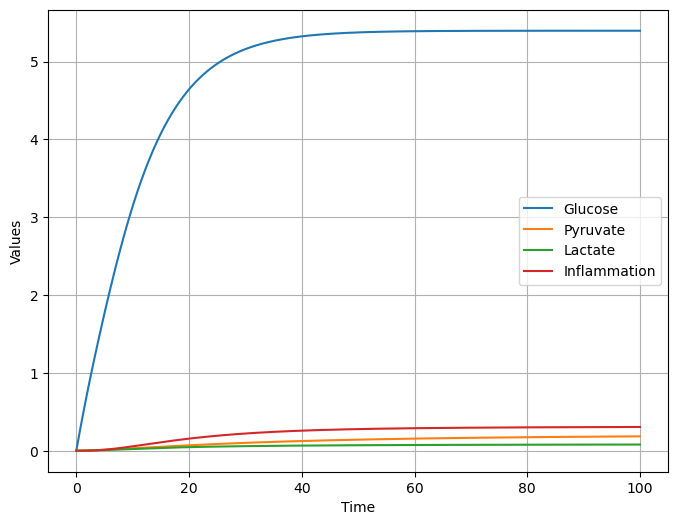

In [2]:
def f(y,t,paras):
    G = y[0]
    P = y[1]
    L = y[2]
    I = y[3]

# build a few functions for short hand
    # inflammation upregulates processes
    lambdafunction =(lambda1 + aIG * I/(bIG + I)) # when I = 0, this is the constant lambda1
    deltafunction = delta + aIP * I/(bIP + I) # when I = 0, this is constant delta
    sigmafunction = sigma + aIL * I/(bIL + I) # when I = 0, this is constant sigma
    # lacate upregulates processes with epigenetic regulation
    h1 = H1 + aLG * L/(bLG + L) # increases glucose to pyruvate flux, function of lactate
    h2 = H2 + aLP * L/(bLP + L) # increaes pyruvate to lactate flux, function of lactate
    inflam = aLI * L/(bLI + L) # lactate increase inflammation
    
    
    f0 = lambdafunction * (GE - G) -  (VP * G)/(KP + G) * h1
    f1 = (VP * G)/(KP + G) * h1 - deltafunction * (VL * P)/(KL + P) * h2 - (1-deltafunction) * (VT * P)/(KT + P)
    f2 = deltafunction * (VL * P)/(KL + P) - sigmafunction * (L - LE)
    f3 = inflam - dI * I # exponential decay
    
    return [f0, f1, f2, f3]

# initial conditions
G0 = 0  # initial glucose
P0 = 0  # initial pyruvate
L0 = 0  # initial lactate
I0 = 0  # initial inflammation

y0 = [G0, P0, L0, I0] # initial condition vector
t = np.linspace(0,100,100000) # time grid, 0 to 100 in 100000 steps


# baseline parameter values
lambda1 = .0755 # glucose import
GE = 5.5 # external glucose
VP = .123 # glucose to pyruvate
KP = 1.7 #glucose to pyruvate
delta = .95 # proportion of pyruvate sent to lactate, 0<=delta<=1
VL = .14 # pyruvte to lactate
KL = .125 # pyruvte to lactate
VT = .15 # pyruvate to TCA
KT = .02 # pyruvate to TCA
sigma = 1 # lactate export
LE = 0 # no external lactate

# inflammation parameters
aLI = .05
bLI = .05
dI = .1

# feeback pieces
# convention: subscript IG means inflammation's influence on glucose

# inflammation influence
aIG = .05
bIG = .05 
aIP = .05
bIP = .05
aIL = .05 # inflammation influence pyruvate to lactate flux and lactate export
bIL = .05 

# lactate influence
aLG = .05 
bLG = .05
H1 = .1
aLP = .05 
bLP = .05 
H2 = .1

# Define parameters
params = (lambda1, GE, VP, KP, delta, VL, KL, VT, KT, sigma, LE, aLI, bLI, dI, aIG, bIG, aIP, bIP, 
          aIL, bIL, aLG, bLG, H1, aLP, bLP, H2)

soln = odeint(f, y0, t, args=(params,))

# Plot the solution
f = plt.figure(figsize=(8, 6))
plt.plot(t, soln)
plt.xlabel('Time')
plt.ylabel('Values')
# plt.title('Solution of the System of Differential Equations')
plt.legend(['Glucose', 'Pyruvate', 'Lactate', 'Inflammation'])
plt.grid(True)
plt.show()


In [3]:
f.savefig("Baseline.pdf")

# Experiment 1: Pan 2022.
The authors added external lactate after inhibiting PKM2.  PKM2 inhibition decreases intracellular lactate, and  the levels can be restored by adding extracellular lactate.  In our model, inhibitiong PKM2 decreases $V_P$, adding external lactate increases $L_E$.
Our model qualitiatively captures this change.  When $V_P$ is set to zero, lactate levels are significantly reduced from baseline because glucose is not converted through glycoloysis.  Lactate can be rescued by increasing $L_E.$

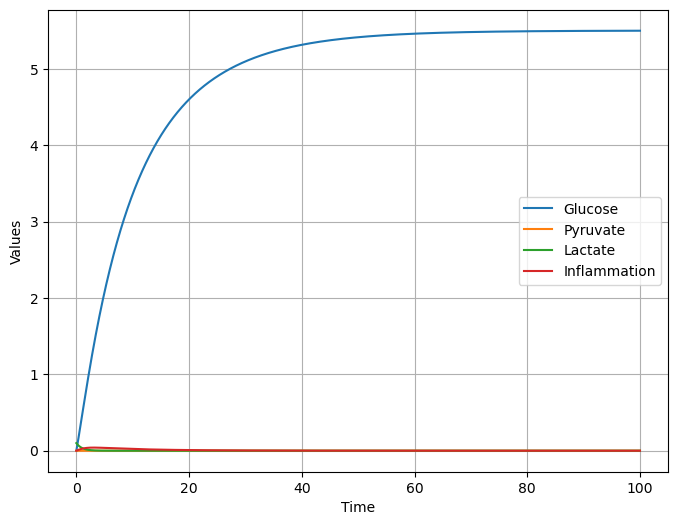

In [4]:
# change from baseline is V_P = 0, and LE = 0

def f(y,t,paras):
    G = y[0]
    P = y[1]
    L = y[2]
    I = y[3]

# build a few functions for short hand
    # inflammation upregulates processes
    lambdafunction =(lambda1 + aIG * I/(bIG + I)) # when I = 0, this is the constant lambda1
    deltafunction = delta + aIP * I/(bIP + I) # when I = 0, this is constant delta
    sigmafunction = sigma + aIL * I/(bIL + I) # when I = 0, this is constant sigma
    # lacate upregulates processes with epigenetic regulation
    h1 = H1 + aLG * L/(bLG + L) # increases glucose to pyruvate flux, function of lactate
    h2 = H2 + aLP * L/(bLP + L) # increaes pyruvate to lactate flux, function of lactate
    inflam = aLI * L/(bLI + L) # lactate increase inflammation
    
    
    f0 = lambdafunction * (GE - G) -  (VP * G)/(KP + G) * h1
    f1 = (VP * G)/(KP + G) * h1 - deltafunction * (VL * P)/(KL + P) * h2 - (1-deltafunction) * (VT * P)/(KT + P)
    f2 = deltafunction * (VL * P)/(KL + P) - sigmafunction * (L - LE)
    f3 = inflam - dI * I # exponential decay
    
    return [f0, f1, f2, f3]

# initial conditions
G0 = 0  # initial glucose
P0 = 0  # initial pyruvate
L0 = .1  # initial lactate
I0 = 0  # initial inflammation

y0 = [G0, P0, L0, I0] # initial condition vector
t = np.linspace(0,100,100000) # time grid, 0 to 100 in 100000 steps



# baseline parameter values
lambda1 = .0755 # glucose import
GE = 5.5 # external glucose
VP = 0 # glucose to pyruvate-- this is knocked out
KP = 1.7 #glucose to pyruvate
delta = .95 # proportion of pyruvate sent to lactate, 0<=delta<=1
VL = .14 # pyruvte to lactate
KL = .125 # pyruvte to lactate
VT = .15 # pyruvate to TCA
KT = .02 # pyruvate to TCA
sigma = 1 # lactate export
LE = 0 # no external lactate

# inflammation parameters
aLI = .05
bLI = .05
dI = .1

# feeback pieces
# convention: subscript IG means inflammation's influence on glucose

# inflammation influence
aIG = .05
bIG = .05 
aIP = .05
bIP = .05
aIL = .05 # inflammation influence pyruvate to lactate flux and lactate export
bIL = .05 

# lactate influence
aLG = .05 
bLG = .05
H1 = .1
aLP = .05 
bLP = .05 
H2 = .1

# Define parameters
params = (lambda1, GE, VP, KP, delta, VL, KL, VT, KT, sigma, LE, aLI, bLI, dI, aIG, bIG, aIP, bIP, 
          aIL, bIL, aLG, bLG, H1, aLP, bLP, H2)

soln = odeint(f, y0, t, args=(params,))

# Plot the solution
f = plt.figure(figsize=(8, 6))
plt.plot(t, soln)
plt.xlabel('Time')
plt.ylabel('Values')
# plt.title('Solution of the System of Differential Equations')
plt.legend(['Glucose', 'Pyruvate', 'Lactate', 'Inflammation'])
plt.grid(True)
plt.show()


In [5]:
f.savefig("InhibitPKM2.pdf")

### Add Exongenous Lactate

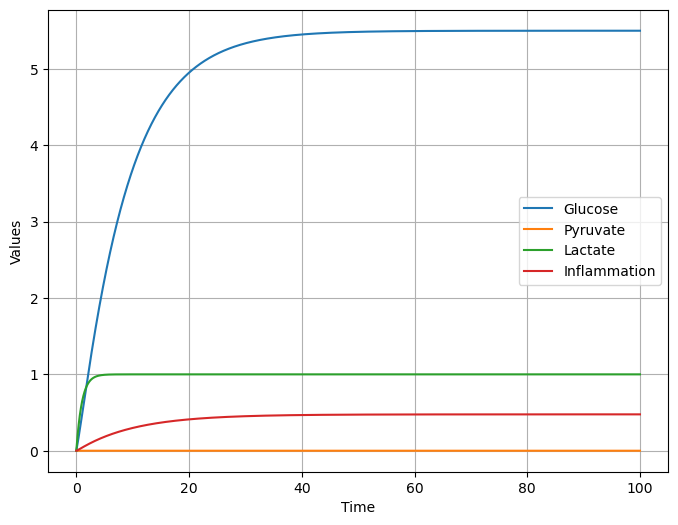

In [6]:
# changes from baseline are V_P and LE

def f(y,t,paras):
    G = y[0]
    P = y[1]
    L = y[2]
    I = y[3]

# build a few functions for short hand
    # inflammation upregulates processes
    lambdafunction =(lambda1 + aIG * I/(bIG + I)) # when I = 0, this is the constant lambda1
    deltafunction = delta + aIP * I/(bIP + I) # when I = 0, this is constant delta
    sigmafunction = sigma + aIL * I/(bIL + I) # when I = 0, this is constant sigma
    # lacate upregulates processes with epigenetic regulation
    h1 = H1 + aLG * L/(bLG + L) # increases glucose to pyruvate flux, function of lactate
    h2 = H2 + aLP * L/(bLP + L) # increaes pyruvate to lactate flux, function of lactate
    inflam = aLI * L/(bLI + L) # lactate increase inflammation
    
    
    f0 = lambdafunction * (GE - G) -  (VP * G)/(KP + G) * h1
    f1 = (VP * G)/(KP + G) * h1 - deltafunction * (VL * P)/(KL + P) * h2 - (1-deltafunction) * (VT * P)/(KT + P)
    f2 = deltafunction * (VL * P)/(KL + P) - sigmafunction * (L - LE)
    f3 = inflam - dI * I # exponential decay
    
    return [f0, f1, f2, f3]

# initial conditions
G0 = 0  # initial glucose
P0 = 0  # initial pyruvate
L0 = 0  # initial lactate
I0 = 0  # initial inflammation

y0 = [G0, P0, L0, I0] # initial condition vector
t = np.linspace(0,100,100000) # time grid, 0 to 1000 in 100000 steps



# baseline parameter values
lambda1 = .0755 # glucose import
GE = 5.5 # external glucose
VP = 0 # glucose to pyruvate
KP = 1.7 #glucose to pyruvate
delta = .95 # proportion of pyruvate sent to lactate, 0<=delta<=1
VL = .14 # pyruvte to lactate
KL = .125 # pyruvte to lactate
VT = .15 # pyruvate to TCA
KT = .02 # pyruvate to TCA
sigma = 1 # lactate export
LE = 1 # external lactate restored

# inflammation parameters
aLI = .05
bLI = .05
dI = .1

# feeback pieces
# convention: subscript IG means inflammation's influence on glucose

# inflammation influence
aIG = .05
bIG = .05 
aIP = .05
bIP = .05
aIL = .05 # inflammation influence pyruvate to lactate flux and lactate export
bIL = .05 

# lactate influence
aLG = .05 
bLG = .05
H1 = .1
aLP = .05 
bLP = .05 
H2 = .1

# Define parameters
params = (lambda1, GE, VP, KP, delta, VL, KL, VT, KT, sigma, LE, aLI, bLI, dI, aIG, bIG, aIP, bIP, 
          aIL, bIL, aLG, bLG, H1, aLP, bLP, H2)

soln = odeint(f, y0, t, args=(params,))

# Plot the solution
f = plt.figure(figsize=(8, 6))
plt.plot(t, soln)
plt.xlabel('Time')
plt.ylabel('Values')
# plt.title('Solution of the System of Differential Equations')
plt.legend(['Glucose', 'Pyruvate', 'Lactate', 'Inflammation'])
plt.grid(True)
plt.show()


In [7]:
f.savefig("LactateRescue.pdf")

Pan, R. Y., He, L., Zhang, J., Liu, X., Liao, Y., Gao, J., ... & Yuan, Z. (2022). Positive feedback regulation of microglial glucose metabolism by histone H4 lysine 12 lactylation in Alzheimer’s disease. Cell metabolism, 34(4), 634-648.